# 2 - Adult

https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

---

Author: Matěj Frič (FRI0089)

Date: 5/1/2023

---

## Columns

This data was extracted from the census bureau database.

- age: continuous.

- workClass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

- finalWeight: continuous.

- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

- educationNum: continuous.

- marital: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

- sex: Female, Male.

- capitalGain: continuous.

- capitalLoss: continuous.

- hoursPerWeek: continuous.

- nativeCountry: United-States, Cambodia, England, ...

People with similar demographic characteristics should have similar weights.

## Task

Predict whether income exceeds $50K/yr based on census data.

In [762]:
import pandas as pd # dataframes
import numpy as np # matrices and linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # another matplotlib interface - styled and easier to use
from tqdm import tqdm
sns.set_style('darkgrid')

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, auc, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import HistGradientBoostingClassifier

from IPython.display import display, Markdown, Latex

np.random.seed(42)

In [763]:
df_original = pd.read_csv('adult.csv',
 sep=',',
 skipinitialspace = True,
 names=["age", "workClass", "finalWeight", "education", "educationNum",
  "marital", "occupation", "relationship", "race", "sex",
  "capitalGain", "capitalLoss", "hoursPerWeek", "nativeCountry", "income"])

# EDA

In [764]:
with pd.option_context('display.max_columns', None):
    display(df_original.head())

,age,workClass,finalWeight,education,educationNum,marital,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [765]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            32561 non-null  int64 
 1   workClass      32561 non-null  object
 2   finalWeight    32561 non-null  int64 
 3   education      32561 non-null  object
 4   educationNum   32561 non-null  int64 
 5   marital        32561 non-null  object
 6   occupation     32561 non-null  object
 7   relationship   32561 non-null  object
 8   race           32561 non-null  object
 9   sex            32561 non-null  object
 10  capitalGain    32561 non-null  int64 
 11  capitalLoss    32561 non-null  int64 
 12  hoursPerWeek   32561 non-null  int64 
 13  nativeCountry  32561 non-null  object
 14  income         32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [766]:
df_original.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
finalWeight,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
educationNum,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capitalGain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capitalLoss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hoursPerWeek,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


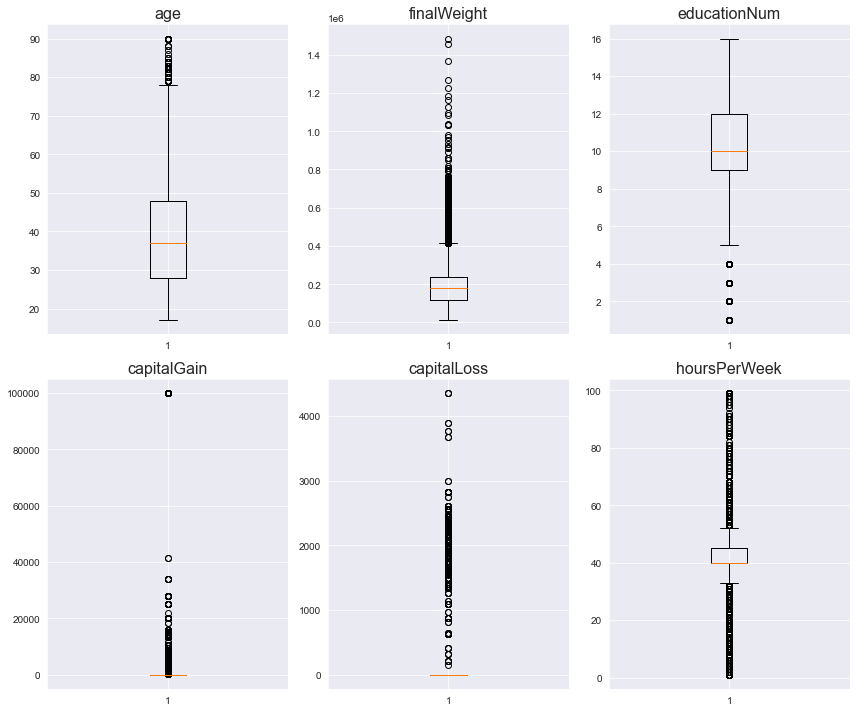

In [767]:
numeric_cols = df_original.select_dtypes(include= np.number).columns.tolist()

cols = 3
rows = int(len(numeric_cols) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 5))

k = -1
for i, col in enumerate(numeric_cols):
    if ((i % 3) == 0):
        k += 1
    axes[k, i % 3].boxplot(df_original[col])
    axes[k, i % 3].set_title(col, fontsize=16)


fig.tight_layout()

- Columns *capitalGain* and *capitalLoss* contain mostly zeros. We convert them to categorical columns.
- There are a lot of outliers in columns *finalWeight* and *hoursPerWeek*. We convert *hoursPerWeek* to categorical values.

In [768]:
for col in numeric_cols:
    print(f'{col}:  {len(df_original[df_original[col] == 0])}')

age:  0
finalWeight:  0
educationNum:  0
capitalGain:  29849
capitalLoss:  31042
hoursPerWeek:  0


In [769]:
categorical_cols = df_original.select_dtypes(exclude= np.number).columns.tolist()
categorical_cols
for col in categorical_cols:
    print(f'{col}: {df_original[col].unique()}')

workClass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
marital: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex: ['Male' 'Female']
nativeCountry: ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 

# Preprocessing

- We change '?' to missing values and
- convert target variable to binary:
  - '>50K'  --> 1,
  - '<=50K' --> 0.

In [770]:
df = df_original.copy()

df.loc[df['workClass'] == '?', 'workClass'] = None
df.loc[df['occupation'] == '?', 'occupation'] = None
df.loc[df['nativeCountry'] == '?', 'nativeCountry'] = None

df['income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)

df.isna().sum().sort_values(ascending=False).head(5)

occupation       1843
workClass        1836
nativeCountry     583
age                 0
finalWeight         0
dtype: int64

## Education

- Order: Preschool < 1st-4th < 5th-6th < 7th-8th < 9th < 10th < 11th < 12th < HS-grad < Prof-school < Assoc-acdm < Assoc-voc < Some-college < Bachelors < Masters < Doctorate.

- We merge high school education into one class (*High-school*), and do the same with  *Assoc-acdm* and *Assoc-voc* (*Associate*).

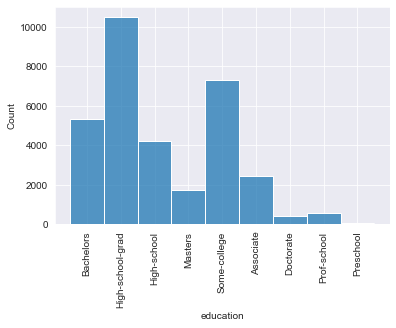

In [771]:
def education(value):
    if any([char.isdigit() for char in value]):
        return 'High-school'
    elif value in ['Assoc-acdm', 'Assoc-voc']:
        return 'Associate'
    elif value == 'HS-grad':
        return 'High-school-grad'
    else:
        return value
df['education'] = df.apply(lambda row: education(row['education']), axis = 1)
sns.histplot(data=df, x='education')
plt.xticks(rotation=90);

## Age

- We create a new column *ageGroup* and drop the *age* column.

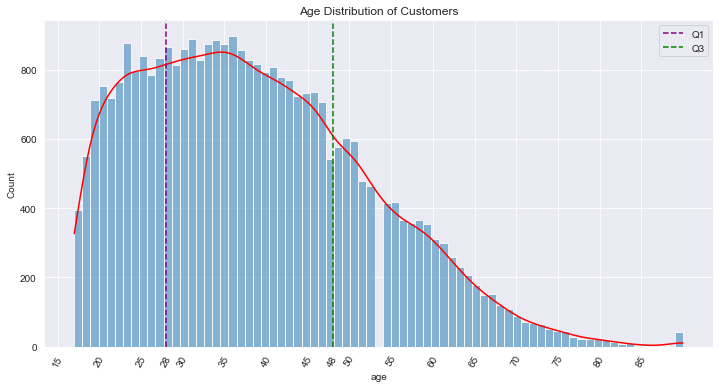

In [772]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df_original, x="age", kde=True, bins=75)
ax.lines[0].set_color('red')
plt.axvline(df['age'].quantile(0.25), color = 'purple', ls='--', label = 'Q1')
plt.axvline(df['age'].quantile(0.75), color = 'green', ls='--', label = 'Q3')
xticks = np.arange(15,90,5).tolist()
xticks.append(df['age'].quantile(0.25))
xticks.append(df['age'].quantile(0.75))
plt.xticks(xticks, rotation=60)
plt.title("Age Distribution of Customers")
plt.legend()
plt.show()

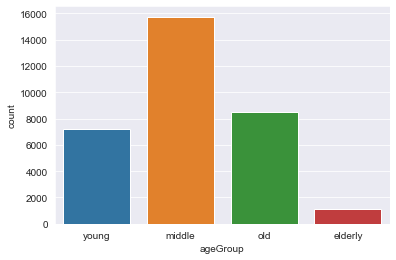

In [773]:
bins=[0, 26, 45, 65, np.inf]
labels=['young', 'middle', 'old', 'elderly']
df['ageGroup'] = pd.cut(df['age'], bins, labels=labels)
sns.countplot(data=df, x='ageGroup');
df = df.drop('age', axis=1)

## Hours per week

- We create a new column *contract* and drop the *hoursPerWeek* column.

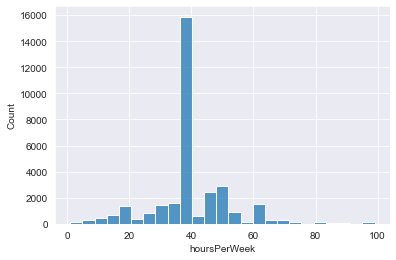

In [774]:
sns.histplot(data=df_original, x = 'hoursPerWeek', bins = 25);

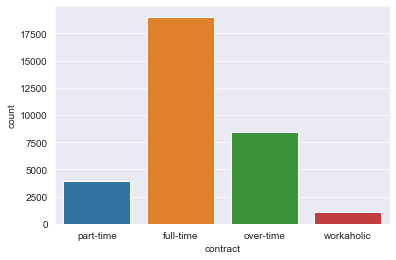

In [775]:
bins = [0,25,40,60,np.inf]
labels = ["part-time", "full-time", "over-time", "workaholic"]
df['contract'] = pd.cut(df['hoursPerWeek'], bins, labels=labels)
sns.countplot(data=df, x='contract')
df = df.drop('hoursPerWeek', axis=1)

## Capital

Since majority of records contain zeros in attributes *capitalLoss* and *capitalGain*, we convert these attributes to categorical values.

- -inf, 0 --> None
- 0, median --> Low
- median, +inf --> High

In [776]:
med = df.loc[df['capitalGain'] > 0, 'capitalGain'].median()
bins = [-np.inf, 0, med, np.inf]
labels = ['none', 'low', 'high']
df['capitalGain'] = pd.cut(df['capitalGain'], bins, labels=labels)

med = df.loc[df['capitalLoss'] > 0, 'capitalLoss'].median()
df['capitalLoss'] = pd.cut(df['capitalLoss'], bins, labels=labels)

In [777]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

df = swap_columns(df, 'income', 'contract')

## Marital

- We reduce the number of classes. More specifically, we merge  *Married-civ-spouse* and *Married-AF-spouse* into *Married*, and *Married-spouse-absent*, *Separated* and *Divorced* into *Not-married*

In [778]:
df['marital'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital, dtype: int64

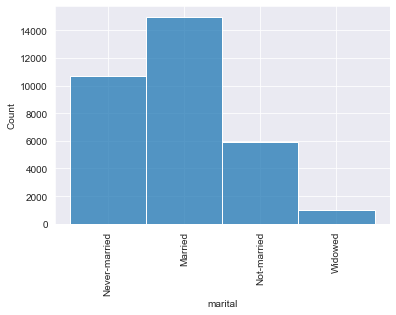

In [779]:
def marital(value):
    if value in ['Married-civ-spouse', 'Married-AF-spouse']:
        return 'Married'
    elif value in ['Married-spouse-absent', 'Separated', 'Divorced']:
        return 'Not-married'
    else:
        return value
df['marital'] = df.apply(lambda row: marital(row['marital']), axis = 1)
sns.histplot(data=df, x='marital')
plt.xticks(rotation=90);

## Workclass
- We remove classes *Without-pay* and *Never-worked* because the number of these records is negligible.

In [780]:
df['workClass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workClass, dtype: int64

In [781]:
df.loc[ (df['workClass'] == 'Without-pay') | (df['workClass'] == 'Never-worked'),  'workClass'] = None

In [782]:
df.sample(10)

,workClass,finalWeight,education,educationNum,marital,occupation,relationship,race,sex,capitalGain,capitalLoss,nativeCountry,contract,ageGroup,income
14160,Private,160178,Some-college,10,Not-married,Adm-clerical,Not-in-family,White,Female,none,none,United-States,full-time,middle,0
27048,State-gov,50567,High-school-grad,9,Married,Exec-managerial,Wife,White,Female,none,none,United-States,full-time,middle,0
28868,Private,185908,Bachelors,13,Married,Exec-managerial,Husband,Black,Male,none,none,United-States,over-time,middle,1
5667,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,none,none,United-States,full-time,middle,0
7827,Self-emp-not-inc,189346,Some-college,10,Not-married,Craft-repair,Not-in-family,White,Male,low,none,United-States,over-time,middle,0
15382,Private,108435,Masters,14,Married,Prof-specialty,Husband,White,Male,none,none,United-States,over-time,old,1
4641,Self-emp-not-inc,93664,High-school-grad,9,Married,Exec-managerial,Husband,White,Male,high,none,United-States,over-time,old,1
8943,Private,148431,High-school-grad,9,Never-married,Adm-clerical,Not-in-family,Other,Female,none,none,United-States,full-time,young,0
216,Private,313321,Associate,12,Not-married,Sales,Not-in-family,White,Female,none,none,United-States,full-time,old,0
5121,Private,71417,High-school-grad,9,Married,Craft-repair,Husband,White,Male,low,none,United-States,full-time,old,1


## Missing data

- We fill in the missing values by propagating the last valid observation. Anyway, this is a negligible part of the data, which is further transformed using one-hot encoding.

In [783]:
print(df.shape)
display(df.isna().sum().sort_values(ascending=False).head(5))
df = df.fillna(method="ffill")
print(df.shape)
display(df.isna().sum().sort_values(ascending=False).head(5))

(32561, 15)


workClass        1857
occupation       1843
nativeCountry     583
finalWeight         0
education           0
dtype: int64

(32561, 15)


workClass       0
finalWeight     0
education       0
educationNum    0
marital         0
dtype: int64

## Scaling

In [784]:
# Numerical columns
numeric_cols = df.select_dtypes(include= np.number).columns.tolist()
df_numeric = df[numeric_cols].copy()
df_numeric = df_numeric.loc[ : , df_numeric.columns != 'income']
df_scaled = pd.DataFrame(
        RobustScaler().fit_transform(df_numeric.values),
    columns=df_numeric.columns)

# Education
education_order = ['Preschool', 'High-school', 'High-school-grad',
 'Prof-school', 'Associate', 'Some-college', 'Bachelors', 'Masters', 'Doctorate']
df_scaled['education'] = MinMaxScaler().fit_transform(
    OrdinalEncoder(categories=[education_order]).fit_transform(df[['education']]))

# Sex
df_scaled['sex']=OrdinalEncoder().fit_transform(df[['sex']])

# Capital
capital_order = ['none', 'low', 'high']
df_scaled['capitalGain'] = MinMaxScaler().fit_transform(
    OrdinalEncoder(categories=[capital_order]).fit_transform(df[['capitalGain']]))
df_scaled['capitalLoss'] = MinMaxScaler().fit_transform(
    OrdinalEncoder(categories=[capital_order]).fit_transform(df[['capitalLoss']]))

# Contract
contract_order = ['part-time', 'full-time', 'over-time', 'workaholic']
df_scaled['contract'] = MinMaxScaler().fit_transform(
    OrdinalEncoder(categories=[contract_order]).fit_transform(df[['contract']]))

# Age
age_order = ['young', 'middle', 'old', 'elderly']
df_scaled['ageGroup'] = MinMaxScaler().fit_transform(
    OrdinalEncoder(categories=[age_order]).fit_transform(df[['ageGroup']]))

# One-hot encoding
df_scaled = df_scaled.join(pd.get_dummies(df[['workClass']]))
df_scaled = df_scaled.join(pd.get_dummies(df[['marital']]))
df_scaled = df_scaled.join(pd.get_dummies(df[['occupation']]))
df_scaled = df_scaled.join(pd.get_dummies(df[['nativeCountry']]))
df_scaled = df_scaled.join(pd.get_dummies(df[['race']]))
df_scaled = df_scaled.join(pd.get_dummies(df[['relationship']]))

# Income
df_scaled.insert(df_scaled.shape[1], 'income', df['income'].values)

with pd.option_context('display.max_columns', None):
    display(df_scaled.head(10))
    display(df_scaled.describe())

,finalWeight,educationNum,education,sex,capitalGain,capitalLoss,contract,ageGroup,workClass_Federal-gov,workClass_Local-gov,workClass_Private,workClass_Self-emp-inc,workClass_Self-emp-not-inc,workClass_State-gov,marital_Married,marital_Never-married,marital_Not-married,marital_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,nativeCountry_Cambodia,nativeCountry_Canada,nativeCountry_China,nativeCountry_Columbia,nativeCountry_Cuba,nativeCountry_Dominican-Republic,nativeCountry_Ecuador,nativeCountry_El-Salvador,nativeCountry_England,nativeCountry_France,nativeCountry_Germany,nativeCountry_Greece,nativeCountry_Guatemala,nativeCountry_Haiti,nativeCountry_Holand-Netherlands,nativeCountry_Honduras,nativeCountry_Hong,nativeCountry_Hungary,nativeCountry_India,nativeCountry_Iran,nativeCountry_Ireland,nativeCountry_Italy,nativeCountry_Jamaica,nativeCountry_Japan,nativeCountry_Laos,nativeCountry_Mexico,nativeCountry_Nicaragua,nativeCountry_Outlying-US(Guam-USVI-etc),nativeCountry_Peru,nativeCountry_Philippines,nativeCountry_Poland,nativeCountry_Portugal,nativeCountry_Puerto-Rico,nativeCountry_Scotland,nativeCountry_South,nativeCountry_Taiwan,nativeCountry_Thailand,nativeCountry_Trinadad&Tobago,nativeCountry_United-States,nativeCountry_Vietnam,nativeCountry_Yugoslavia,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,income
0,-0.845803,1.000000,0.750,1.0,0.5,0.0,0.333333,0.333333,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,-0.797197,1.000000,0.750,1.0,0.0,0.0,0.000000,0.666667,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0.312773,-0.333333,0.250,1.0,0.0,0.0,0.333333,0.333333,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,0.472766,-1.000000,0.125,1.0,0.0,0.0,0.333333,0.666667,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,1.342456,1.000000,0.750,0.0,0.0,0.0,0.333333,0.333333,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5,0.890978,1.333333,0.875,0.0,0.0,0.0,0.333333,0.333333,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6,-0.152394,-1.666667,0.125,0.0,0.0,0.0,0.000000,0.666667,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
7,0.262414,-0.333333,0.250,1.0,0.0,0.0,0.666667,0.666667,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1
8,-1.111982,1.333333,0.875,0.0,1.0,0.0,0.666667,0.333333,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
9,-0.158584,1.000000,0.750,1.0,0.5,0.0,0.333333,0.333333,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1


,finalWeight,educationNum,education,sex,capitalGain,capitalLoss,contract,ageGroup,workClass_Federal-gov,workClass_Local-gov,workClass_Private,workClass_Self-emp-inc,workClass_Self-emp-not-inc,workClass_State-gov,marital_Married,marital_Never-married,marital_Not-married,marital_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,nativeCountry_Cambodia,nativeCountry_Canada,nativeCountry_China,nativeCountry_Columbia,nativeCountry_Cuba,nativeCountry_Dominican-Republic,nativeCountry_Ecuador,nativeCountry_El-Salvador,nativeCountry_England,nativeCountry_France,nativeCountry_Germany,nativeCountry_Greece,nativeCountry_Guatemala,nativeCountry_Haiti,nativeCountry_Holand-Netherlands,nativeCountry_Honduras,nativeCountry_Hong,nativeCountry_Hungary,nativeCountry_India,nativeCountry_Iran,nativeCountry_Ireland,nativeCountry_Italy,nativeCountry_Jamaica,nativeCountry_Japan,nativeCountry_Laos,nativeCountry_Mexico,nativeCountry_Nicaragua,nativeCountry_Outlying-US(Guam-USVI-etc),nativeCountry_Peru,nativeCountry_Philippines,nativeCountry_Poland,nativeCountry_Portugal,nativeCountry_Puerto-Rico,nativeCountry_Scotland,nativeCountry_South,nativeCountry_Taiwan,nativeCountry_Thailand,nativeCountry_Trinadad&Tobago,nativeCountry_United-States,nativeCountry_Vietnam,nativeCountry_Yugoslavia,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,income
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.095806,0.026893,0.463277,0.669205,0.059350,0.046651,0.402414,0.370075,0.030773,0.067780,0.740549,0.036148,0.082553,0.042198,0.460643,0.328092,0.180768,0.030497,0.122294,0.000307,0.134025,0.132582,0.031879,0.045177,0.065539,0.106569,0.004883,0.134701,0.020976,0.118639,0.030128,0.052302,0.000614,0.003808,0.002365,0.001873,0.002979,0.002273,0.000860,0.003348,0.002856,0.000891,0.004330,0.000921,0.002027,0.001382,0.000031,0.000399,0.000614,0.000399,0.003102,0.001321,0.000737,0.002242,0.002549,0.001935,0.000584,0.020178,0.001044,0.000430,0.000952,0.006142,0.001843,0.001136,0.003624,0.000369,0.002457,0.001566,0.000553,0.000584,0.911950,0.002211,0.000522,0.009551,0.031909,0.095943,0.008323,0.854274,0.405178,0.255060,0.030128,0.155646,0.105832,0.048156,0.240810
std,0.885308,0.857573,0.249028,0.470506,0.209426,0.210893,0.229656,0.260602,0.172705,0.251373,0.438340,0.186660,0.275209,0.201043,0.498456,0.469526,0.384832,0.171952,0.327630,0.017522,0.340685,0.339128,0.175680,0.207695,0.247477,0.308570,0.069710,0.341409,0.143306,0.323368,0.170942,0.222638,0.0247

# Classification

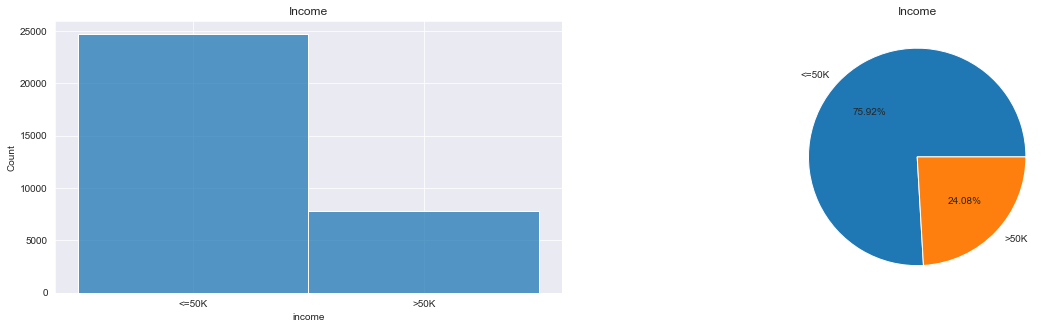

In [785]:
plt.figure(figsize=(20,5))
w = 2
plt.subplot(1,w,1)
sns.histplot(data=df_original, x='income')
plt.title('Income')
plt.subplot(1,w,2)
plt.pie(x=df_original["income"].value_counts().values,
                labels=df_original["income"].value_counts().index.to_list(),
                autopct='%.2f%%',)
plt.title('Income');

- Target variable is imbalanced. Therefore, we use stratified sampling.

In [786]:
y = df_scaled['income'] # Target variable
X = df_scaled.drop(['income'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [787]:
class Score:
    def __init__(self, accuracy, f1score, roc_auc) -> None:
        self.accuracy = accuracy
        self.f1score = f1score
        self.roc_auc = roc_auc

25it [00:09,  2.61it/s]

Best K = 15


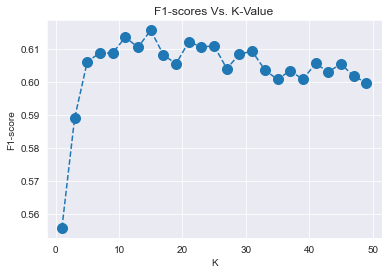

In [788]:
k_values = np.arange(1,50,2)
scores = np.zeros(len(k_values))
best_k = 0
best_i = 0
for i, k in tqdm(enumerate(k_values)):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    scores[i] = f1_score(y_test, y_pred)
    if scores[best_i] < scores [i]:
        best_i = i
        best_k = k

print(f'Best K = {best_k}')

plt.plot(k_values, scores, linestyle='dashed', marker='o', markersize=10)
plt.title('F1-scores Vs. K-Value')
plt.xlabel('K')
plt.ylabel('F1-score')
plt.show()

In [789]:
classifiers = [DecisionTreeClassifier(random_state = 42),
               GaussianNB(), 
               SGDClassifier(loss='modified_huber', shuffle=True, random_state = 42),
               SGDClassifier(loss='perceptron', shuffle=True, random_state = 42),
               SGDClassifier(loss='hinge', shuffle=True, random_state = 42),
               SGDClassifier(loss='log_loss', shuffle=True, random_state = 42),
               RandomForestClassifier(n_estimators=50, random_state = 42),
               RandomForestClassifier(n_estimators=100, random_state = 42),
               RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 42),
               HistGradientBoostingClassifier(loss = 'log_loss'),
               AdaBoostClassifier(n_estimators=50),
               AdaBoostClassifier(n_estimators=100),
               KNeighborsClassifier(n_neighbors=best_k),
               SVC(kernel = 'rbf', cache_size = 1000),
               Perceptron(),
               Perceptron(penalty = 'l2', early_stopping = True),
               MLPClassifier(hidden_layer_sizes=(8,4), activation='relu', solver='adam', max_iter=1000, random_state=42),
               MLPClassifier(hidden_layer_sizes=(8,4), activation='relu', solver='sgd', max_iter=1000, random_state=42),
               MLPClassifier(hidden_layer_sizes=(8,4), activation='logistic', solver='adam', max_iter=1000, random_state=42),
               MLPClassifier(hidden_layer_sizes=(16,8), activation='logistic', solver='adam', max_iter=1000, random_state=42),
               MLPClassifier(hidden_layer_sizes=(8,4), activation='logistic', solver='sgd', max_iter=1000, random_state=42),
              ]

output =  "| Classifier | Accuracy | F1-score | ROC AUC |\n|----------|----------|----------|---------|\n" # Header
newline = '\n'

for clf in tqdm(classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = list()
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(
            Score(accuracy_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            roc_auc_score(y_test, y_pred)))
    accuracy = np.mean([x.accuracy for x in scores])
    f1score = np.mean([x.f1score for x in scores])
    roc_auc = np.mean([x.roc_auc for x in scores])
    output += f"| {str(clf).replace(newline,'')} | {accuracy:.3f} | {f1score:.3f} | {roc_auc:.3f} |\n"

display(Markdown(output))

100%|██████████| 21/21 [10:22<00:00, 29.64s/it] 


| Classifier | Accuracy | F1-score | ROC AUC |
|----------|----------|----------|---------|
| DecisionTreeClassifier(random_state=42) | 0.796 | 0.583 | 0.726 |
| GaussianNB() | 0.544 | 0.502 | 0.683 |
| SGDClassifier(loss='modified_huber', random_state=42) | 0.837 | 0.627 | 0.750 |
| SGDClassifier(loss='perceptron', random_state=42) | 0.808 | 0.561 | 0.718 |
| SGDClassifier(random_state=42) | 0.844 | 0.660 | 0.771 |
| SGDClassifier(loss='log_loss', random_state=42) | 0.844 | 0.642 | 0.756 |
| RandomForestClassifier(n_estimators=50, random_state=42) | 0.828 | 0.624 | 0.747 |
| RandomForestClassifier(random_state=42) | 0.829 | 0.623 | 0.747 |
| RandomForestClassifier(criterion='entropy', random_state=42) | 0.829 | 0.626 | 0.748 |
| HistGradientBoostingClassifier() | 0.854 | 0.671 | 0.774 |
| AdaBoostClassifier() | 0.852 | 0.657 | 0.763 |
| AdaBoostClassifier(n_estimators=100) | 0.853 | 0.662 | 0.767 |
| KNeighborsClassifier(n_neighbors=15) | 0.832 | 0.612 | 0.736 |
| SVC(cache_size=1000) | 0.850 | 0.649 | 0.756 |
| Perceptron() | 0.796 | 0.531 | 0.711 |
| Perceptron(early_stopping=True, penalty='l2') | 0.803 | 0.600 | 0.751 |
| MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=1000, random_state=42) | 0.847 | 0.660 | 0.769 |
| MLPClassifier(hidden_layer_sizes=(8, 4), max_iter=1000, random_state=42,              solver='sgd') | 0.847 | 0.650 | 0.760 |
| MLPClassifier(activation='logistic', hidden_layer_sizes=(8, 4), max_iter=1000,              random_state=42) | 0.851 | 0.669 | 0.774 |
| MLPClassifier(activation='logistic', hidden_layer_sizes=(16, 8), max_iter=1000,              random_state=42) | 0.853 | 0.669 | 0.773 |
| MLPClassifier(activation='logistic', hidden_layer_sizes=(8, 4), max_iter=1000,              random_state=42, solver='sgd') | 0.759 | 0.000 | 0.500 |


# Summary

In this study, we tested the use of supervised machine learning algorithms to predict whether an individual's income exceeds $50,000 per year based on census data. The algorithms were trained on a dataset containing a variety of demographic and economic features, including education level, occupation, and age. In total, we performed 21 experiments.

We achieved the best results with *Histogram-based Gradient Boosting Classification Tree* (see [sklearn.ensemble.HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)). Closely behind was the *Multilayer Perceptron Classifier*, which might be even better with more suitable hyperparameters, followed by the *AdaBoost Classifier* and the *Support Vector Classifier*.

| Classifier | Accuracy | F1-score | ROC AUC | 
|----------|----------|----------|----------|
| HistGradientBoostingClassifier() | 0.854 | 0.671 | 0.774 |
| MLPClassifier(activation='logistic', hidden_layer_sizes=(16, 8)) | 0.853 | 0.669 | 0.773 |
| AdaBoostClassifier(n_estimators=100) | 0.853 | 0.662 | 0.767 |
| SVC(cache_size=1000) | 0.850 | 0.649 | 0.756 |

From my perspective, either *F1-score* or *ROC AUC* is the most important, as *accuracy* can be a misleading metric in unbalanced datasets (which is our case).

There is still room for improvement, as different preprocessing techniques and hyperparameter settings could potentially yield even better results. [2]

# References

[1] https://sites.google.com/site/complexdataminingproject/

[2] This summary was generated with the assistance of ChatGPT: https://openai.com/blog/chatgpt/